In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torchvision.utils import save_image

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("moltean/fruits")

print("Path to dataset files:", path)

train_path = os.path.join(path, "fruits-360_100x100", "fruits-360", "Training")
test_path = os.path.join(path, "fruits-360_100x100", "fruits-360", "Test")

print("Train folder:", train_path)
print("Test folder:", test_path)

/home/annguyen/classes/genAI/fruit-generator/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/annguyen/.cache/kagglehub/datasets/moltean/fruits/versions/41
Train folder: /home/annguyen/.cache/kagglehub/datasets/moltean/fruits/versions/41/fruits-360_100x100/fruits-360/Training
Test folder: /home/annguyen/.cache/kagglehub/datasets/moltean/fruits/versions/41/fruits-360_100x100/fruits-360/Test


In [3]:
# --- CONFIG ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sample_dir = 'samples'
checkpoint_dir = 'checkpoints'
os.makedirs(sample_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, 'vae_checkpoint.pth')

In [4]:
# --- HYPERPARAMETERS ---
IMAGE_SIZE = 64
LATENT_DIM = 40
NUM_EPOCHS = 20
BATCH_SIZE = 64
LR_RATE = 1e-3
BETA = 1

In [5]:
from torchvision import datasets, transforms

# --- DATASET PREP ---
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
# --- DATASET INFO ---

sample, label = train_dataset[0]
print(f"Transformed image shape: {sample.shape}")
print(f"Classes: {train_dataset.classes}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Number of images in training set: {len(train_dataset)}")

Transformed image shape: torch.Size([3, 64, 64])
Classes: ['Apple 10', 'Apple 11', 'Apple 12', 'Apple 13', 'Apple 14', 'Apple 17', 'Apple 18', 'Apple 19', 'Apple 5', 'Apple 6', 'Apple 7', 'Apple 8', 'Apple 9', 'Apple Braeburn 1', 'Apple Core 1', 'Apple Crimson Snow 1', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith 1', 'Apple Pink Lady 1', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious 1', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apple Rotten 1', 'Apple hit 1', 'Apple worm 1', 'Apricot 1', 'Avocado 1', 'Avocado Black 1', 'Avocado Green 1', 'Avocado ripe 1', 'Banana 1', 'Banana 3', 'Banana Lady Finger 1', 'Banana Red 1', 'Beans 1', 'Beetroot 1', 'Blackberrie 1', 'Blackberrie 2', 'Blackberrie half rippen 1', 'Blackberrie not rippen 1', 'Blueberry 1', 'Cabbage red 1', 'Cabbage white 1', 'Cactus fruit 1', 'Cactus fruit green 1', 'Cactus fruit red 1', 'Caju seed 1', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula 1', 'Carrot 1', 'Cauliflower 1', 

In [7]:
from torchsummary import summary

# --- VAE MODEL ---
# Image size: 64 × 64 × 3 (RGB image)
#
# Encoder: (shrink spatial size, grow channels)
#   - Input: [3, 64, 64] (image with 3 channels)
#   - Conv2D: [3, 64, 64] → [32, 32, 32]
#   - Conv2D: [32, 32, 32] → [64, 16, 16]
#   - Conv2D: [64, 16, 16] → [128, 8, 8]
#   - Conv2D: [128, 8, 8] → [256, 4, 4]
#   - Conv2D: [256, 4, 4] → [512, 2, 2]
#   - Flatten: [512, 2, 2] → [2048]
#   - Two heads:
#       * Linear: [2048] → [20] (mean of latent z)
#       * Linear: [2048] → [20] (log-variance of latent z)
#
# Decoder:
#   - Input: [20] (sampled latent z)
#   - Linear: [20] → [2048]
#   - Reshape: [2048] → [512, 2, 2]
#   - ConvTranspose2D: [512, 2, 2] → [256, 4, 4]
#   - ConvTranspose2D: [256, 4, 4] → [128, 8, 8]
#   - ConvTranspose2D: [128, 8, 8] → [64, 16, 16]
#   - ConvTranspose2D: [64, 16, 16] → [32, 32, 32]
#   - ConvTranspose2D: [32, 32, 32] → [3, 64, 64]

class VAE(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super(VAE, self).__init__()

        # --- Encoder ---
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        self.flatten_dim =  512 * 2 * 2     # after 5 layers, get 2x2 spatial size
        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

        # --- Decoder ---
        self.fc_decode = nn.Linear(latent_dim, self.flatten_dim)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1),  
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),  
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),   
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),    
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),     
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(x.size(0), -1)
        z_mean = self.fc_mu(h)
        z_log_var = self.fc_logvar(h)
        return z_mean, z_log_var

    def reparameterize(self, z_mean, z_log_var):
        std = torch.exp(0.5 * z_log_var)
        epsilon = torch.randn_like(std)
        z = z_mean + std * epsilon
        return z

    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(-1, 512, 2, 2)
        x = self.decoder(h)
        return x

    def forward(self, x):
        z_mean, z_log_var = self.encode(x)
        z = self.reparameterize(z_mean, z_log_var)
        x_recon = self.decode(z)
        return x_recon, z_mean, z_log_var

In [8]:
model = VAE(latent_dim=LATENT_DIM).to(device)
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
       BatchNorm2d-5           [-1, 64, 16, 16]             128
              ReLU-6           [-1, 64, 16, 16]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
       BatchNorm2d-8            [-1, 128, 8, 8]             256
              ReLU-9            [-1, 128, 8, 8]               0
           Conv2d-10            [-1, 256, 4, 4]         295,168
      BatchNorm2d-11            [-1, 256, 4, 4]             512
             ReLU-12            [-1, 256, 4, 4]               0
           Conv2d-13            [-1, 512, 2, 2]       1,180,160
      BatchNorm2d-14            [-1, 51

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR_RATE)

In [10]:
# --- LOAD CHECKPOINT IF EXISTS ---
start_epoch = 0
if os.path.isfile(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Resumed from epoch {start_epoch}")

Resumed from epoch 11


In [11]:
def vae_loss(reconstructed_x, x, z_mean, z_log_var):
    # Reconstruction loss 
    recon_loss = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')

    # KL divergence
    kl_div = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())

    # Total loss
    return recon_loss + BETA*kl_div, recon_loss, kl_div

In [12]:
# --- TRAINING LOOP ---
for epoch in range(start_epoch, NUM_EPOCHS):
    for i, (x, _) in enumerate(data_loader):
        x = x.to(device)  # keep (B, 3, 64, 64)

        x_reconst, z_mean, z_log_var = model(x)
        loss, recon_loss, kl_div = vae_loss(x_reconst, x, z_mean, z_log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 10 == 0:
            print(f"Epoch[{epoch + 1}/{NUM_EPOCHS}], Step [{i + 1}/{len(data_loader)}], "
                  f"Recon Loss: {recon_loss.item():.4f}, KL Div: {kl_div.item():.4f}")

    with torch.no_grad():
        z = torch.randn(BATCH_SIZE, LATENT_DIM).to(device)
        out = model.decode(z)  # decode random z
        save_image(out, os.path.join(sample_dir, f'sampled-{epoch + 1}.png'))

        out, _, _ = model(x)
        x_concat = torch.cat([x, out], dim=3)  # concat original + recon
        save_image(x_concat, os.path.join(sample_dir, f'reconst-{epoch + 1}.png'))

    # --- SAVE CHECKPOINT ---
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch + 1}")

Epoch[12/20], Step [10/1577], Recon Loss: 406345.5000, KL Div: 0.0470
Epoch[12/20], Step [20/1577], Recon Loss: 396441.3438, KL Div: 0.0400
Epoch[12/20], Step [30/1577], Recon Loss: 399585.1875, KL Div: 0.0413
Epoch[12/20], Step [40/1577], Recon Loss: 396833.0625, KL Div: 0.0377
Epoch[12/20], Step [50/1577], Recon Loss: 401181.9688, KL Div: 0.0528
Epoch[12/20], Step [60/1577], Recon Loss: 397008.1250, KL Div: 0.0613
Epoch[12/20], Step [70/1577], Recon Loss: 404135.5625, KL Div: 0.0553
Epoch[12/20], Step [80/1577], Recon Loss: 405627.8125, KL Div: 0.0462
Epoch[12/20], Step [90/1577], Recon Loss: 405314.9375, KL Div: 0.0377
Epoch[12/20], Step [100/1577], Recon Loss: 397147.3438, KL Div: 0.0317
Epoch[12/20], Step [110/1577], Recon Loss: 395750.7188, KL Div: 0.0303
Epoch[12/20], Step [120/1577], Recon Loss: 406339.4375, KL Div: 0.0266
Epoch[12/20], Step [130/1577], Recon Loss: 407247.8438, KL Div: 0.0228
Epoch[12/20], Step [140/1577], Recon Loss: 405056.2812, KL Div: 0.0217
Epoch[12/20], S

In [16]:
import matplotlib.pyplot as plt
from datetime import datetime

def generate_random_samples(model, latent_dim, device, num_samples=16, output_prefix='random_sample', show_plot=True):
    # Generate timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    output_file = f'{output_prefix}_{timestamp}.png'

    # Generate random latent vectors and decode
    model.eval()
    z = torch.randn(num_samples, latent_dim).to(device)
    with torch.no_grad():
        generated = model.decode(z)
    
    # Save image grid
    save_image(generated, output_file, nrow=4)
    print(f"Saved random samples to {output_file}")

    # Display
    if show_plot:
        imgs = generated.cpu().numpy().transpose(0, 2, 3, 1)
        plt.figure(figsize=(8, 8))
        for i in range(num_samples):
            plt.subplot(4, 4, i + 1)
            plt.imshow(imgs[i])
            plt.axis('off')
        plt.tight_layout()
        plt.show()


Saved random samples to random_sample_20250507_231257.png


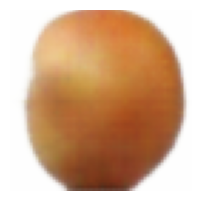

In [20]:
generate_random_samples(model, LATENT_DIM, device, num_samples=1)

In [21]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
saved_weights_path = 'saved_weights_VAE/vae_weights' + timestamp+'.pth'
torch.save(model.state_dict(), saved_weights_path)